In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point, box
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

from collections import Counter
from tqdm import tqdm
from pyproj import CRS
import pyproj
import osmnx as ox
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import shap
import joblib
import datetime

# Loading in the points data

In [2]:
# Input the name of the city that you are analysing
city_name = "Stockholm, Sweden"

# Choose the local projected coordinate system that your satellite images are in
local_crs = "EPSG:3006"

# Output map resolution (in meters)
resolution = 60

In [3]:
buffer_sizes = [30, 100, 200, 500, 1000]

In [490]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Outputs/ML_data/Netatmo_Filtered.csv')

# Convert latitude and longitude to Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]

# Create a GeoDataFrame from the DataFrame and the geometry
points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Reproject to local CRS
points = points.to_crs(local_crs)

date = pd.to_datetime(points['time']).dt.strftime('%Y%m%d')
points.loc[:, 'date'] = date

input_data = points.copy()

In [491]:
input_data

,p_id,time,lon,lat,z,ta,geometry,date
0,1,2018-05-20 16:00:00,18.052986,59.392158,25,26.0,POINT (673363.004 6587697.062),20180520
1,2,2018-05-20 19:00:00,18.002964,59.426637,48,25.3,POINT (670350.537 6591404.715),20180520
2,5,2018-05-20 17:00:00,18.312525,59.419384,18,23.5,POINT (687942.344 6591431.365),20180520
3,6,2018-05-20 16:00:00,18.333351,59.417235,20,27.6,POINT (689135.275 6591251.339),20180520
4,7,2018-05-20 16:00:00,18.339703,59.429265,21,27.5,POINT (689428.240 6592608.010),20180520
...,...,...,...,...,...,...,...,...
4487,594,2023-07-14 16:00:00,17.885192,59.507595,13,26.9,POINT (663281.267 6600118.893),20230714
4488,596,2023-07-14 17:00:00,17.921103,59.248356,68,23.1,POINT (666579.563 6571357.619),20230714
4489,598,2023-07-14 17:00:00,18.280605,59.433109,18,25.6,POINT (686056.892 6592868.871),20230714
4490,599,2023-07-14 17:00:00,18.284754,59.289146,14,26.7,POINT (687083.051 6576861.908),20230714


# Computing all Temporal Features

The first block of this section normalizes the satellite images and band indices, as well as removes any outliers (defined using z-score thresholding). 

Next, mean and standard deviation is computed for all optical imagery (bands and band indices) at all radii around each Netatmo station point.

In [ ]:
# Z-score calculation
def calculate_z_scores(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    return (arr - mean) / std

# Main folder for analysis
main_folder = 'Inputs/Analysis_Dates/'

# Z-score threshold for outlier removal
z_score_threshold = 3 

# Band and LST definitions for rescaling
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
LST = ['LST']

# Loop through subfolders in the main folder
for date_folder in os.listdir(main_folder):
    date_folder_path = os.path.join(main_folder, date_folder)
    
    if os.path.isdir(date_folder_path):
        # Create 'Rescaled' folder inside each date folder
        rescaled_folder = os.path.join(date_folder_path, 'Rescaled')
        os.makedirs(rescaled_folder, exist_ok=True)

        # Filter .tif files
        filtered_files = [
            file for file in os.listdir(date_folder_path) 
            if file.endswith('.tif') and 'pw_wtr' not in file and 'QA' not in file and 'B10' not in file
        ]

        # Process filtered files with a progress bar
        for filename in tqdm(filtered_files, desc=f"Processing rasters in {date_folder}"):
            filepath = os.path.join(date_folder_path, filename)
            with rasterio.open(filepath) as src:
                # Read raster as float and update profile
                raster = src.read(1).astype(float)
                profile = src.profile
                profile.update(dtype=rasterio.float32)

                # Z-score computation
                z_scores = calculate_z_scores(raster)

                # Outlier removal
                raster[np.abs(z_scores) > z_score_threshold] = np.nan

                # Rescale based on file type
                if any(band in filename for band in bands):
                    raster /= 10000
                elif 'LST' in filename:
                    raster /= 300

                # Save rescaled raster
                with rasterio.open(os.path.join(rescaled_folder, filename), 'w', **profile) as dst:
                    dst.write(raster, 1)


In [577]:
# Calculate mean and std for a raster and a buffered point
def calculate_stats(raster_path, buffered_point):
    with rasterio.open(raster_path) as src:
        # Read raster values within the buffer bounds
        raster_window = src.read(1, window=src.window(*buffered_point.bounds))
        masked_raster, _ = mask(src, [buffered_point], crop=True, nodata=-9999)
        
        # Mask invalid values (-9999 or nodata)
        masked_raster = np.ma.masked_where((masked_raster == -9999) | (masked_raster == src.nodata), masked_raster)      
        
        # Calculate NaN percentage
        nan_percentage = np.isnan(masked_raster).mean() * 100

        # If not entirely NaN, calculate mean and std
        if nan_percentage < 100:
            mean_value = np.nanmean(masked_raster)
            std_value = np.nanstd(masked_raster)
        else:
            mean_value = np.nan
            std_value = np.nan

        return mean_value, std_value

# Lists for storing mean and std values
mean_values = []
std_values = []

total_rows = len(buffer_sizes) * len(input_data)

with tqdm(total=total_rows) as pbar:  # Progress bar for total iterations
    for buffer in buffer_sizes: 
        for index, row in input_data.iterrows():
            date = row['date']
            folder_path = os.path.join('Inputs', 'Analysis_Dates', str(date), 'Rescaled')

            # Get raster files for the current date
            filtered_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]

            if filtered_files:
                for variable in filtered_files:
                    raster_path = os.path.join(folder_path, variable)

                    # Read point geometry and create buffer
                    point_geom = row['geometry']
                    buffered_point = point_geom.buffer(buffer)

                    # Compute mean and std for the buffered area
                    mean_value, std_value = calculate_stats(raster_path, buffered_point)

                    # Define column names based on buffer and variable
                    variable_keyword = variable.split('_')[1].split('.')[0]
                    mean_column_name = f'{buffer}_{variable_keyword}_mean'
                    std_column_name = f'{buffer}_{variable_keyword}_std'

                    # Append values to the lists
                    mean_values.append(mean_value)
                    std_values.append(std_value)

                # Add mean and std values to the DataFrame
                mean_columns = [f'{buffer}_{file.split("_")[1].split(".")[0]}_mean' for file in filtered_files]
                std_columns = [f'{buffer}_{file.split("_")[1].split(".")[0]}_std' for file in filtered_files]
                input_data.loc[index, mean_columns] = mean_values
                input_data.loc[index, std_columns] = std_values

                # Clear the lists for the next iteration
                mean_values.clear()
                std_values.clear()

                pbar.update(1)  # Update progress bar after processing

            else:
                print(f"No raster files found for date {date}.")
print('Finished computing for all temporal data!')


100%|██████████████████████████████████████████████████████████████████████████████| 4492/4492 [06:31<00:00, 11.47it/s]

Finished computing for all temporal data!


In [493]:
folder_path = os.path.join('Outputs', 'ML_data')
os.makedirs(folder_path, exist_ok=True)

csv_path = os.path.join(folder_path, 'temporal_dataframe_1000.csv')
input_data.to_csv(csv_path, index=False)

# Computing for Non-Temporal Features

The first block of this section normalizes the satellite images and band indices, as well as removes any outliers (defined using z-score thresholding). 

Next, mean and standard deviation is computed for all optical imagery (bands and band indices) at all radii around each Netatmo station point.

This computes the terrain variable predictors for both 30m and LiDAR data. For LiDAR, only the first three buffers are computed, as when applying the model to the full study site, it becomes too computationally intensive to use LiDAR variables at 1km radii.

In [431]:
# Z-score calculation function
def calculate_z_scores(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    return (arr - mean) / std

# Folders to process
folders = ['Inputs/Non_Temporal/Lidar_terrain', 'Inputs/Non_Temporal/Terrain30']

# Z-score threshold for outlier removal
z_score_threshold = 3

for folder in folders:
    # Create 'Rescaled' folder inside each folder
    rescaled_folder = os.path.join(folder, 'Rescaled')
    os.makedirs(rescaled_folder, exist_ok=True)

    # List of raster files in the folder
    rasters = [f for f in os.listdir(folder) if f.endswith('.tif')]

    # Process each raster with a progress bar
    for filename in tqdm(rasters, desc=f"Processing rasters in {folder}"):
        filepath = os.path.join(folder, filename)
        with rasterio.open(filepath) as src:
            # Read raster as float and update profile to float32
            raster = src.read(1).astype(float)
            profile = src.profile
            profile.update(dtype=rasterio.float32)

            # Calculate z-scores
            z_scores = calculate_z_scores(raster)

            # Remove outliers (set to NaN)
            raster[np.abs(z_scores) > z_score_threshold] = np.nan

            # Flatten the raster and remove NaN values for scaling
            raster_flat = raster[~np.isnan(raster)].reshape(-1, 1)

            # Min-Max scaling
            scaler = MinMaxScaler()
            raster_scaled_flat = scaler.fit_transform(raster_flat).flatten()

            # Rebuild the scaled raster with original NaN positions
            raster_scaled = np.full(raster.shape, np.nan, dtype=np.float32)
            raster_scaled[~np.isnan(raster)] = raster_scaled_flat

            # Save the rescaled raster
            with rasterio.open(os.path.join(rescaled_folder, filename), 'w', **profile) as dst:
                dst.write(raster_scaled, 1)

Processing rasters in Inputs/Non_Temporal/Lidar_terrain: 100%|███████████████████████████| 8/8 [01:57<00:00, 14.73s/it]
Processing rasters in Inputs/Non_Temporal/Terrain30: 100%|███████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]


In [495]:
input_data = gpd.read_file('Outputs/ML_data/temporal_dataframe_1000.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

In [ ]:
def process_rasters(grouped_data, buffer_sizes, folder):
    print(f"Processing rasters in folder: {folder}")
    mean_values = []
    std_values = []

    # Define folder paths
    base_folder_path = os.path.join('Inputs', 'Non_Temporal')
    folder_path = os.path.join(base_folder_path, folder)

    # Filter for .tif files in the folder
    filtered_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]

    if not filtered_files:
        print(f"No raster files found in {folder_path}.")
        return

    # Calculate total iterations for the progress bar
    total_rows = len(buffer_sizes) * len(grouped_data)
    
    # Initialize progress bar
    with tqdm(total=total_rows) as pbar:
        for variable in filtered_files:
            print(f"Loading raster file: {variable}")
            raster_path = os.path.join(folder_path, variable)

            # Open the raster file
            with rasterio.open(raster_path) as src:
                raster_data = src.read(1)  # Read raster data
                transform = src.transform  # Get transform info
                raster_bounds = src.bounds  # Get raster bounds
                raster_bbox = box(*raster_bounds)  # Create bounding box for the raster

                # Extract variable name from file
                variable_keyword = variable.split('.')[0]

                # Iterate over buffer sizes
                for buffer in buffer_sizes:
                    # Process each group of data points
                    for p_id, group in grouped_data:
                        for index, row in group.iterrows():
                            point_geom = row['geometry']  # Get point geometry
                            buffered_point = point_geom.buffer(buffer)  # Create buffer around point

                            # Check if buffer intersects with the raster's bounding box
                            if buffered_point.intersects(raster_bbox):
                                # Mask raster within the buffered area
                                masked_raster, _ = mask(src, [buffered_point], crop=True, nodata=-9999)
                                
                                # Mask invalid values (-9999 and nodata)
                                masked_raster = np.ma.masked_where((masked_raster == -9999) | (masked_raster == src.nodata), masked_raster)
                                
                                # Calculate percentage of NaN values
                                nan_percentage = np.isnan(masked_raster).mean() * 100
                                
                                # If data is valid, compute mean and std
                                if nan_percentage < 100:
                                    mean_value = np.nanmean(masked_raster)
                                    std_value = np.nanstd(masked_raster)
                                else:
                                    mean_value = np.nan
                                    std_value = np.nan
                                    print(f"No valid data for index {index}: setting mean and std to NaN")
                            else:
                                # If no intersection, set values to NaN
                                mean_value = np.nan
                                std_value = np.nan

                            # Define column names for mean and std
                            mean_col = f'{buffer}_{variable_keyword}_mean'
                            std_col = f'{buffer}_{variable_keyword}_std'

                            # Store calculated values in the DataFrame
                            input_data.at[index, mean_col] = mean_value
                            input_data.at[index, std_col] = std_value

                        # Update progress bar after processing each buffer size
                        pbar.update(1)

# Group input_data by 'p_id'
grouped_data = input_data.groupby('p_id')

# Process 'Lidar_terrain' for the first three buffer sizes
process_rasters(grouped_data, buffer_sizes[:3], 'Lidar_terrain/Rescaled')

# Process 'Terrain30' for all buffer sizes
process_rasters(grouped_data, buffer_sizes, 'Terrain30/Rescaled')

print('Finished computing for all non-temporal data!')


In [ ]:
folder_path = os.path.join('Outputs', 'ML_data')
os.makedirs(folder_path, exist_ok=True)
    
csv_path = os.path.join(folder_path, 'ML_dataframe_2000.csv')
input_data.to_csv(csv_path, index=False)

# Spatiotemporal Training Data Splitting

Split the data into testing and training set. Training data points are station recordings at all stations with a history spanning back to 2020 or earlier, and testing data points are weather station recordings at all stations with a history more recent than 2020. 

In [4]:
input_data = gpd.read_file('Outputs/ML_data/ML_dataframe_1000.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

In [6]:
# Replace empty strings with NaN
input_data.replace('', np.nan, inplace=True)

# Initialize KNN imputer for missing data
knn_imputer = KNNImputer(n_neighbors=5)

# Drop non-numeric columns before imputation
input_data_dropped = input_data.drop(columns=['time', 'geometry', 'date'])

# Perform KNN imputation and create a DataFrame with the same columns
input_data_imputed = pd.DataFrame(knn_imputer.fit_transform(input_data_dropped), columns=input_data_dropped.columns)

# Reattach the non-numeric columns after imputation
input_data = input_data_imputed.join(input_data[['time', 'geometry', 'date']])

# Filter data for years 2018-2020 for the training set
training_points = input_data[(input_data['date'].str[:4].astype(int) >= 2018) & (input_data['date'].str[:4].astype(int) <= 2020)]

# Filter data for years 2021-2023 for the testing set
testing_points = input_data[(input_data['date'].str[:4].astype(int) > 2020) & (input_data['date'].str[:4].astype(int) <= 2023)]

# Identify shared station IDs between training and testing sets
unique_station_ids = training_points['p_id'].unique()
shared_testing_points = testing_points[testing_points['p_id'].isin(unique_station_ids)]

# Exclude shared station IDs from the testing set
testing_points = testing_points[~testing_points['p_id'].isin(unique_station_ids)]

# Append shared testing points to the training set
training_points = pd.concat([training_points, shared_testing_points])

# Prepare feature matrices (X) and target variables (y) for training and testing sets
X_train = training_points.drop(columns=['ta', 'time', 'geometry', 'p_id', 'lon', 'lat', 'z', 'date'])  # Drop target and unneeded columns
X_test = testing_points.drop(columns=['ta', 'time', 'geometry', 'p_id', 'lon', 'lat', 'z', 'date'])
y_train = training_points['ta']  # Target variable for training
y_test = testing_points['ta']  # Target variable for testing


In [7]:
print(len(y_train), len(y_test))

3061 1431


# Training all Machine Learning Models

This block trains and evaluates three machine learning models (Random Forest, Gradient Boosting, and Linear Regression) using all features and selected subsets of top features based on SHAP values. 

It calculates performance metrics (RMSE and R-squared) and saves both the trained models and the evaluation results. Additionally, the code selects top features based on SHAP importance, retrains the models with these subsets, and stores the results in a CSV file for further analysis.

In [ ]:
# Function to train models and evaluate performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    return rmse, r2

# Function to compute SHAP values
def get_shap_values(X_test, model):
    # Use appropriate SHAP explainer based on model type
    if isinstance(model, LinearRegression):
        explainer = shap.LinearExplainer(model, X_test)
    else:
        explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    return explainer, shap_values

# Function to select top k features based on SHAP values
def select_top_k_features(shap_values, original_features, k):
    # Compute mean absolute SHAP values and select top k features
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    shap_sorted_idx = shap_abs_mean.argsort()[::-1]
    top_k_features = [original_features[i] for i in shap_sorted_idx[:k]]
    return top_k_features

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression()
}

# Define feature set sizes for evaluation
feature_sizes = [None, 75, 50, 25]

# List to store evaluation results
results_list = []

# Iterate over models
for model_name, model in models.items():
    original_features = X_train.columns.tolist()  # Save the full set of features

    # Train and evaluate model with all features
    X_train_model = X_train[original_features]
    X_test_model = X_test[original_features]
    print(f"Training {model_name} with all features.")
    
    model.fit(X_train_model, y_train)  # Train the model
    rmse, r2 = evaluate_model(model, X_test_model, y_test)  # Evaluate the model
    print(f"Evaluation results for {model_name} with all features: RMSE={rmse}, R-squared={r2}")

    # Store results for model with all features
    results_list.append({
        'Model': model_name,
        'Feature Set': 'All_Features',
        'RMSE': rmse,
        'R-squared': r2,
        'Num_Features': len(original_features)
    })

    # Compute SHAP values for all features
    explainer, shap_values = get_shap_values(X_test_model, model)
    print(f"Computed SHAP values for {model_name} with all features.")

    # Iterate over feature set sizes for top k feature selection
    for k in feature_sizes[1:]:
        selected_features = select_top_k_features(shap_values, original_features, k)
        print(f"Selected top {k} features for {model_name}.")

        # Train and evaluate model with top k features
        X_train_model = X_train[selected_features]
        X_test_model = X_test[selected_features]
        print(f"Training {model_name} with top {k} features.")

        model.fit(X_train_model, y_train)  # Train model with selected features
        rmse, r2 = evaluate_model(model, X_test_model, y_test)  # Evaluate model
        print(f"Evaluation results for {model_name} with top {k} features: RMSE={rmse}, R-squared={r2}")

        # Store results for top k features
        results_list.append({
            'Model': model_name,
            'Feature Set': f'Top_{k}_Features',
            'RMSE': rmse,
            'R-squared': r2,
            'Num_Features': len(selected_features)
        })

        # Save the trained model
        savepath = f'Outputs/ML_models/DynamicSelection/Tavg_All_Buffers_{model_name}_Top_{k}.pkl'
        joblib.dump(model, savepath)
        results_list[-1]['File path'] = savepath  # Store model file path
        print(f"Saved {model_name} model with top {k} features to {savepath}")

# Create DataFrame from results list
results_df = pd.DataFrame(results_list)

# Save the results DataFrame to CSV
results_df.to_csv('Outputs/ML_models/DynamicSelection/Tavg_All_Buffers_results_df.csv', index=False)

# Print results for debugging
print("Results DataFrame:")
print(results_df)


# Machine Learning Modelling Results

Presents the results of the modelling, and selects the best performing model. Creates visualizations on the breakdown of the most important features. 

In [ ]:
results_df = pd.read_csv('Outputs/ML_models/DynamicSelection/Tavg_All_Buffers_results_df.csv')
results_df

In [ ]:
# Find the index of the model with the lowest RMSE
best_model_index = results_df['RMSE'].idxmin()

# Get the file path of the best model based on the lowest RMSE
best_model_path = results_df.loc[best_model_index]['File path']

# Print the file path of the best-performing model
print(best_model_path)

# Load the best model from the saved file
model = joblib.load(best_model_path)

# Extract and print the feature names used by the best model
feature_names = model.feature_names_in_
feature_names

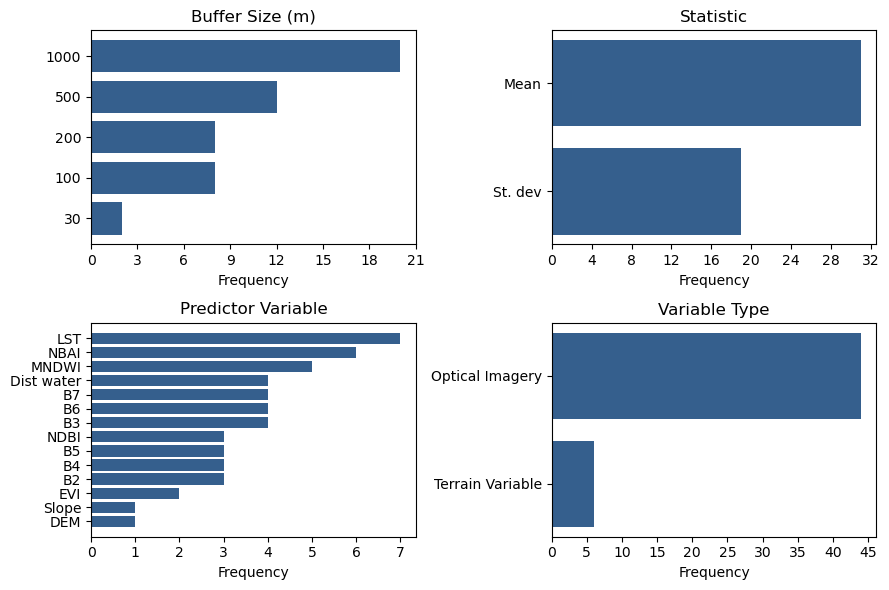

In [129]:
# Ensure the 'Figures' directory exists for saving plots
os.makedirs('Figures', exist_ok=True)

# Initialize lists for parsing feature information
top_features = feature_names.tolist()
buffers = []
stats = []
variables = []
temporal_labels = []

# Keywords for identifying temporal variables
temporal_keywords = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'LST', 'EVI', 'MNDWI', 'NBAI', 'NDBI', 'NDVI', 'SAVI']

# Loop through the top features to categorize them
for feature in top_features:
    parts = feature.split("_")
    buffers.append(parts[0])  # Extract buffer size
    stats.append(parts[-1])  # Extract statistic (mean, std)
    middle = parts[1:-1]  # Extract the variable name
    variables.append("_".join(middle))  # Join variable parts if more than one

    # Categorize as either 'Optical Imagery' or 'Terrain Variable'
    if any(keyword in feature for keyword in temporal_keywords):
        temporal_labels.append('Optical Imagery')
    else:
        temporal_labels.append('Terrain Variable')

# Function to get the frequency count of elements in a list
def get_frequencies(data):
    counter = Counter(data)  # Count occurrences
    sorted_items = sorted(counter.items(), key=lambda x: (x[1], x[0]), reverse=False)  # Sort by frequency
    return [item[0] for item in sorted_items], [item[1] for item in sorted_items]

# Function to format labels for better readability
def format_label(label):
    if label == 'std':
        return 'St. dev'  # Replace 'std' with 'St. dev'
    label = label.replace("_", " ")  # Replace underscores with spaces
    return label[0].upper() + label[1:]  # Capitalize the first letter

# Get frequency data for buffers, stats, variables, and temporal labels
buffers_keys, buffers_values = get_frequencies(buffers)
stats_keys, stats_values = get_frequencies(stats)
variables_keys, variables_values = get_frequencies(variables)
temporal_keys, temporal_values = get_frequencies(temporal_labels)

# Format the keys for better display in plots
buffers_keys = [format_label(key) for key in buffers_keys]
stats_keys = [format_label(key) for key in stats_keys]
variables_keys = [format_label(key) for key in variables_keys]
temporal_keys = [format_label(key) for key in temporal_keys]

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Set the color for the bars from the 'viridis' color palette
viridis_color = cm.viridis(0.3)

# Function to plot horizontal bar charts
def plot_barh(ax, keys, values, title):
    ax.barh(keys, values, color=viridis_color)  # Plot bars
    ax.set_title(title)  # Set plot title
    ax.set_xlabel('Frequency')  # Set x-axis label
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis ticks are integers

# Plot frequency of buffer sizes
plot_barh(axs[0, 0], buffers_keys, buffers_values, 'Buffer Size (m)')

# Plot frequency of statistics (mean, std)
plot_barh(axs[0, 1], stats_keys, stats_values, 'Statistic')

# Plot frequency of predictor variables
plot_barh(axs[1, 0], variables_keys, variables_values, 'Predictor Variable')

# Plot frequency of variable types (Optical Imagery or Terrain Variable)
plot_barh(axs[1, 1], temporal_keys, temporal_values, 'Variable Type')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure to the 'Figures' directory
plt.savefig('Figures/feature_summary_plot.png')

# Display the plot
plt.show()


In [25]:
def get_shap_values(X_test, model):
    # Compute SHAP values on data
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    return shap_values
 
model.fit(X_train, y_train)
shap_values = get_shap_values(X_test, model)

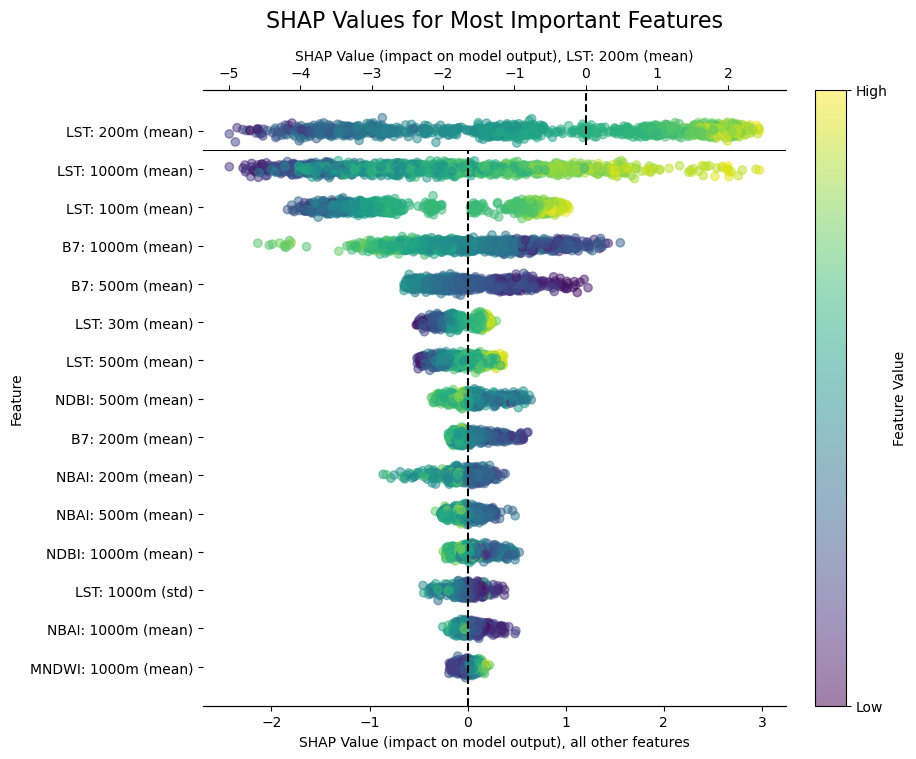

In [125]:
# Function to format labels for features in a more readable format
def format_label(label):
    parts = label.split('_')
    if len(parts) == 3:
        return f"{parts[1]}: {parts[0]}m ({parts[2]})"  # Format for buffer, variable, and stat (e.g., 'mean', 'std')
    elif len(parts) == 2:
        return f"{parts[1]}: {parts[0]}m"  # Format for buffer and variable
    else:
        return label  # Return the label as is if it's not in the expected format

# Function to plot SHAP summary for the top N features
def plot_shap_summary(shap_values, X_test, top_n=15):
    # Get the mean absolute SHAP values for each feature (feature importance)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)[::-1]  # Sort indices by descending SHAP importance
    top_columns = X_test.columns[sorted_idx[:top_n]]  # Select top N features

    # Normalize the selected features in X_test for coloring the plot
    scaler = MinMaxScaler()
    X_test_selected_normalized = pd.DataFrame(scaler.fit_transform(X_test[top_columns]), columns=top_columns)

    # Define the magnitude of jitter for adding variation to y-axis values
    jitter = 0.08

    # Create a plot figure with a primary axis (ax1)
    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.3)  # Adjust layout to leave space for y-axis labels

    # Plot SHAP values for each feature with jitter on the primary axis
    for i, col in enumerate(top_columns):
        y_jitter = (len(top_columns) - i - 1) + np.random.normal(loc=0, scale=jitter, size=len(shap_values))  # Add jitter to the y-axis
        if i == 0:
            ax1.scatter(0, 0, label=col, alpha=0)  # Dummy scatter for the first column to set the label
        else:
            ax1.scatter(shap_values[:, sorted_idx[i]], y_jitter, c=X_test_selected_normalized[col], label=col, alpha=0.5, cmap='viridis')

    # Set the y-axis labels with formatted feature names
    y_labels = [format_label(col) for col in top_columns]
    plt.yticks(range(len(top_columns)), y_labels[::-1])  # Reverse the labels to match the plot order

    # Add vertical and horizontal reference lines
    ax1.axvline(x=0, ymax=0.90, color='black', linestyle='--')  # Vertical line at x=0
    ax1.axhline(y=13.5, color='black', linestyle='-', linewidth=0.75)  # Horizontal line for separation

    # Set axis labels and title for the primary axis
    ax1.set_xlabel('SHAP Value (impact on model output), all other features')
    ax1.set_ylabel('Feature')
    ax1.set_title('SHAP Values for Most Important Features', fontsize=16, pad=16)

    # Create a secondary x-axis (ax2) for overlaying another set of plots
    ax2 = ax1.twiny()
    for i, col in enumerate(top_columns):
        y_jitter = (len(top_columns) - i - 1) + np.random.normal(loc=0, scale=jitter, size=len(shap_values))  # Add jitter for secondary axis
        if i != 0:
            ax2.scatter(0, 0, label=col, alpha=0)  # Dummy scatter for columns other than the first one
        else:
            ax2.scatter(shap_values[:, sorted_idx[i]], y_jitter, c=X_test_selected_normalized[col], label=col, alpha=0.5, cmap='viridis')

    # Add a vertical line on the secondary axis for visual alignment
    ax2.axvline(x=0, ymin=0.91, color='black', linestyle='--')

    # Label the secondary x-axis with a reference to the most important feature
    ax2.set_xlabel('SHAP Value (impact on model output), ' + format_label(top_columns[0]))

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Add a color bar to show the range of feature values
    cb = plt.colorbar(lines2[0], ax=[ax1, ax2], location='right', pad=-0.05)
    cb.set_label('Feature Value')  # Label for the color bar
    cb.set_ticks([0, 1])  # Set the ticks at the extremes of the color scale
    cb.set_ticklabels(['Low', 'High'])  # Set labels for the ticks

    # Remove unnecessary spines from both axes
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Save the figure as a PNG file
    plt.savefig('Figures/SHAP_summary_plot.png')

    # Display the plot
    plt.show()

# Example usage:
plot_shap_summary(shap_values, X_test)

# Producing Air Temperature Estimates

Applying the trained model to each analysis date to estimate air temperature across the study site. 

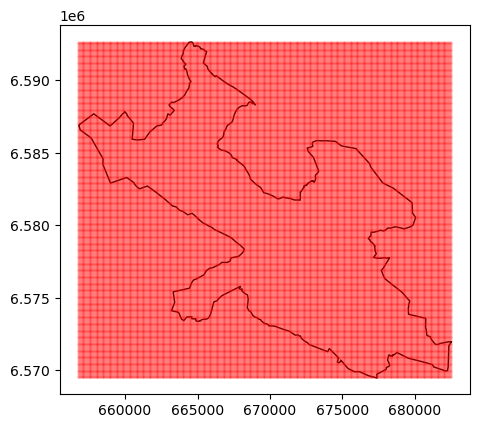

In [11]:
# Get city boundaries in a GeoDataFrame using OSMnx
city = ox.geocode_to_gdf(city_name)

# Reproject the city boundaries to the local coordinate reference system (CRS)
city = city.to_crs(local_crs)

# Calculate the bounding box (min and max coordinates) of the city geometry
min_x, min_y, max_x, max_y = city.geometry.total_bounds

# Generate x and y coordinates at regular intervals (based on the defined resolution) within the bounding box
x_coords = np.arange(min_x, max_x, resolution)
y_coords = np.arange(min_y, max_y, resolution)

# Create a grid of x and y points using meshgrid, then flatten the arrays and combine them into a list of points
xx, yy = np.meshgrid(x_coords, y_coords)
points = np.vstack([xx.ravel(), yy.ravel()]).T  # Stack x and y points vertically

# Convert the grid points to a GeoDataFrame using the same CRS as the city
grid_points_clipped = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in points], crs=city.crs)

# Plot the city boundaries and overlay the grid points
ax = city.plot(color='white', edgecolor='black')  # Plot city boundaries
grid_points_clipped.plot(ax=ax, color='red', markersize=0.01)  # Plot grid points as red dots

# Display the plot
plt.show()


In [9]:
grid_points_clipped.shape

(166023, 1)

In [632]:
# Create an empty DataFrame for non-temporal variables with columns as feature names
df_non_temporal = pd.DataFrame(columns=feature_names)

# List of folders containing non-temporal raster data
non_temporal_folders = [
    'Inputs/Non_Temporal/Terrain30/Rescaled',
    'Inputs/Non_Temporal/Lidar_terrain/Rescaled'
]

# Process non-temporal variables for each feature name
for feature_name in feature_names:
    parts = feature_name.split("_")  # Split feature name into parts (buffer, variable, statistic)
    buffer = float(parts[0])  # Extract buffer size and convert to float
    stat = parts[-1]  # Extract statistic (mean, std)
    middle = parts[1:-1]  # Extract the variable name
    variable = "_".join(middle)  # Join variable name parts

    values_list = []  # List to store computed values for the current feature
    found = False  # Flag to check if the corresponding raster file is found

    # Loop through non-temporal folders to locate the raster file
    for folder in non_temporal_folders:
        filepath = os.path.join(folder, f'{variable}.tif')  # Construct file path for the variable

        # Check if the raster file exists
        if os.path.exists(filepath):
            with rasterio.open(filepath) as src:
                raster_data = src.read(1)  # Read the raster data
                transform = src.transform  # Get the transform info
                raster_bounds = src.bounds  # Get the bounds of the raster
                raster_bbox = box(*raster_bounds)  # Create a bounding box from the raster bounds

                # Iterate over grid points and apply buffering
                for index, row in tqdm(grid_points_clipped.iterrows(), total=grid_points_clipped.shape[0], desc=f'Processing {variable} with buffer {buffer}'):
                    point_geom = row['geometry']  # Get the geometry of the point
                    buffered_point = point_geom.buffer(buffer)  # Create a buffer around the point

                    # Check if the buffered point intersects the raster bounding box
                    if buffered_point.intersects(raster_bbox):
                        # Mask the raster within the buffered area, exclude nodata values
                        masked_raster, _ = mask(src, [buffered_point], crop=True, nodata=-9999)
                        masked_raster = np.ma.masked_where((masked_raster == -9999) | (masked_raster == src.nodata), masked_raster)
                        nan_percentage = np.isnan(masked_raster).mean() * 100  # Calculate percentage of NaN values

                        # If there are valid data points (NaN percentage <= 99%), compute the statistic
                        if nan_percentage <= 99:
                            if stat == 'mean':
                                value = np.nanmean(masked_raster)  # Calculate mean if the stat is 'mean'
                            elif stat == 'std':  
                                value = np.nanstd(masked_raster)  # Calculate standard deviation if the stat is 'std'
                            values_list.append(value)  # Append the value to the list
                        else:
                            values_list.append(np.nan)  # Append NaN if too much missing data
                        found = True  # Set found flag to True if the file is processed successfully
                    else:
                        values_list.append(np.nan)  # Append NaN if the point does not intersect the raster

            if found:
                # Append the computed values to the DataFrame as a column for the current feature
                df_non_temporal[feature_name] = values_list
                break  # Exit the folder loop once the file is found and processed

# Save the non-temporal DataFrame to a CSV file
output_file_non_temporal = f'Outputs/ML_data/Final/All_Buffers_{resolution}m_non_temporal.csv'
df_non_temporal.to_csv(output_file_non_temporal, index=False)  # Save the DataFrame without row index
print(f'Non-temporal data saved to {output_file_non_temporal}')

Processing dist_water with buffer 1000.0: 100%|██████████████████████████████| 166023/166023 [02:43<00:00, 1017.16it/s]


Non-temporal data saved to Outputs/ML_data/Final/All_Buffers_60m_non_temporal.csv


In [ ]:
# Function to get a list of date folders in the specified directory
def get_date_folders(path):
    date_folders = []
    for folder in os.listdir(path):
        if os.path.isdir(os.path.join(path, folder)):  # Check if it's a directory
            date_folders.append(folder)
    return date_folders

# Get the list of date folders from the 'Inputs/Analysis_Dates' directory
date_folders = get_date_folders('Inputs/Analysis_Dates/')

# Load the non-temporal data from the CSV file
df_non_temporal = pd.read_csv(f'Outputs/ML_data/Final/All_Buffers_{resolution}m_non_temporal.csv')
df_non_temporal = df_non_temporal.dropna(axis=1, how='all')  # Drop columns with all NaN values
print(df_non_temporal.shape)

# Iterate over each date folder to process temporal variables
for date_folder in date_folders:
    output_file = f'Outputs/Temp_Mapping/Tavg_{date_folder}.tif'

    # Skip processing if the output file already exists
    if os.path.exists(output_file):
        print(f"Output file for {date_folder} already exists. Skipping...")
        continue  # Move to the next date folder

    print(f'Processing Date: {date_folder}')
    
    # Create an empty DataFrame for temporal variables
    df_temporal = pd.DataFrame(columns=feature_names)

    # Iterate over each feature in feature_names
    for feature_name in feature_names:
        parts = feature_name.split("_")  # Split the feature name to extract buffer, variable, and stat
        buffer = float(parts[0])  # Extract buffer size and convert to float
        stat = parts[-1]  # Extract the statistic (mean or std)
        middle = parts[1:-1]  # Extract the variable name
        variable = "_".join(middle)  # Join parts of the variable name
        values_list = []  # List to store computed values for each feature

        # Construct the filepath for the temporal raster file
        filepath = os.path.join(f'Inputs/Analysis_Dates/{date_folder}/{date_folder}_{variable}.tif')
        found = False  # Flag to check if the file is found

        if os.path.exists(filepath):
            found = True
            with rasterio.open(filepath) as src:
                raster_data = src.read(1)  # Read the raster data
                transform = src.transform  # Get the raster transformation
                raster_bounds = src.bounds  # Get raster bounds
                raster_bbox = box(*raster_bounds)  # Create bounding box from raster bounds

                # Iterate over grid points and buffer them
                for index, row in tqdm(grid_points_clipped.iterrows(), total=grid_points_clipped.shape[0], desc=f'Processing {variable} with buffer {buffer}'):
                    point_geom = row['geometry']  # Get point geometry
                    buffered_point = point_geom.buffer(buffer)  # Create a buffer around the point

                    # Check if the buffered point intersects with the raster bounding box
                    if buffered_point.intersects(raster_bbox):
                        # Mask the raster with the buffered geometry
                        masked_raster, _ = mask(src, [buffered_point], crop=True, nodata=-9999)
                        masked_raster = np.ma.masked_where((masked_raster == -9999) | (masked_raster == src.nodata), masked_raster)
                        nan_percentage = np.isnan(masked_raster).mean() * 100  # Calculate percentage of NaN values

                        # Rescale bands or LST values if necessary
                        if any(band in filepath for band in bands):
                            masked_raster = masked_raster / 10000
                        elif 'LST' in filepath:
                            masked_raster = masked_raster / 300

                        # Calculate the stat (mean or std) if valid data exists
                        if nan_percentage < 100:
                            if stat == 'mean':
                                value = np.nanmean(masked_raster)
                            elif stat == 'std':
                                value = np.nanstd(masked_raster)
                            values_list.append(value)
                        else:
                            values_list.append(np.nan)  # Append NaN if data is mostly missing
                    else:
                        values_list.append(np.nan)  # Append NaN if no intersection with the raster

            # If the file is found and processed, add values to the DataFrame
            if found:
                df_temporal[feature_name] = values_list

        else:
            # Drop columns with all NaN values if the file isn't found
            df_temporal = df_temporal.dropna(axis=1, how='all')

    # Combine non-temporal and temporal DataFrames
    df_combined = pd.concat([df_non_temporal, df_temporal], axis=1)

    # Impute missing values in the combined DataFrame using median imputation
    imputer = SimpleImputer(strategy='median')
    df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_combined), columns=df_combined.columns)
    df_combined_imputed = df_combined_imputed.reindex(feature_names, axis=1)

    # Use the model to predict temperature values
    predictions = model.predict(df_combined_imputed)
    grid_points_clipped['tmean'] = predictions  # Store predictions in the GeoDataFrame

    # Define raster properties for the output file
    xmin, ymin, xmax, ymax = city.geometry.total_bounds
    res = resolution
    nx = int((xmax - xmin) / res)
    ny = int((ymax - ymin) / res)

    # Create an empty array for the rasterized data
    raster_array = np.zeros((ny, nx))

    # Define the transform for the raster
    transform = from_origin(xmin, ymax, res, res)

    # Prepare geometries and values for rasterization
    shapes = [(geom, value) for geom, value in zip(grid_points_clipped.geometry, grid_points_clipped['tmean'])]

    # Rasterize the points onto the raster array
    rasterize(
        shapes,
        out=raster_array,
        fill=0,
        transform=transform,
        all_touched=True,
        default_value=0,  # Set default value to 0
        dtype=np.float64
    )

    # Save the raster to the output file
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        width=raster_array.shape[1],
        height=raster_array.shape[0],
        count=1,
        dtype=raster_array.dtype,
        crs=grid_points_clipped.crs,
        transform=transform,
    ) as dst:
        dst.write(raster_array, 1)  # Write the data to the raster

    print(f'Raster for {date_folder} saved to {output_file}')


(166023, 6)
Processing Date: 20180520


Processing NBAI with buffer 100.0: 100%|█████████████████████████████████████| 166023/166023 [02:09<00:00, 1282.12it/s]


Raster for 20180520 saved to Outputs/Temp_Mapping/Tavg_20180520.tif
Processing Date: 20180716


Processing NBAI with buffer 100.0: 100%|█████████████████████████████████████| 166023/166023 [02:10<00:00, 1276.70it/s]


Raster for 20180716 saved to Outputs/Temp_Mapping/Tavg_20180716.tif
Processing Date: 20180801


Processing NBAI with buffer 30.0:  20%|███████▉                               | 33773/166023 [00:22<01:29, 1474.14it/s]

# Predicting for unseen imagery

Loading in unseen images (not used in model training) and making predictions for air temperature. 

In [ ]:
# Function to calculate z-scores
def calculate_z_scores(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    z_scores = (arr - mean) / std
    return z_scores
 
# Define the main folder and the subfolders
main_folder = 'Inputs/Analysis_Dates/Unseen_Dates'
 
# Define the z-score threshold for outlier removal
z_score_threshold = 3  # Modify this threshold as needed
 
# Define bands and LST for rescaling
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
LST = ['LST']
 
# Iterate over all subfolders in the main folder
for date_folder in os.listdir(main_folder):
    date_folder_path = os.path.join(main_folder, date_folder)
    if os.path.isdir(date_folder_path):
        # Create 'Rescaled' subfolder
        rescaled_folder = os.path.join(date_folder_path, 'Rescaled')
        os.makedirs(rescaled_folder, exist_ok=True)
 
        # Filter specific files
        filtered_files = [
            file for file in os.listdir(date_folder_path) 
            if file.endswith('.tif') and 'pw_wtr' not in file and 'QA' not in file and 'B10' not in file
        ]
 
        # Iterate over filtered files in the subfolder with a progress bar
        for filename in tqdm(filtered_files, desc=f"Processing rasters in {date_folder}"):
            filepath = os.path.join(date_folder_path, filename)
            with rasterio.open(filepath) as src:
                # Read the raster and convert to float
                raster = src.read(1).astype(float)
                profile = src.profile
                profile.update(dtype=rasterio.float32)  # Ensure the output is float32
 
                # Calculate z-scores
                z_scores = calculate_z_scores(raster)
 
                # Remove outliers
                raster[np.abs(z_scores) > z_score_threshold] = np.nan
 
                # Apply specific rescaling based on filename
                if any(band in filename for band in bands):
                    raster /= 10000
                elif 'LST' in filename:
                    raster /= 300
 
                # Save the rescaled raster
                with rasterio.open(os.path.join(rescaled_folder, filename), 'w', **profile) as dst:
                    dst.write(raster, 1)

In [13]:
# Define bands and LST for rescaling
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
LST = ['LST']

# Function to get list of dates
def get_date_folders(path):
    date_folders = []
    for folder in os.listdir(path):
        if os.path.isdir(os.path.join(path, folder)):
            date_folders.append(folder)
    return date_folders
 
# Get list of date folders
date_folders = get_date_folders('Inputs/Analysis_Dates/Unseen_Dates')
 
df_non_temporal = pd.read_csv(f'Outputs/ML_data/Final/All_Buffers_{resolution}m_non_temporal.csv')
df_non_temporal = df_non_temporal.dropna(axis=1, how='all')
print(df_non_temporal.shape)
 
# Iterate over dates
for date_folder in date_folders:
    output_file = f'Outputs/Temp_Mapping/Tavg_{date_folder}_UNSEEN.tif'
    # Check if output file already exists
    if os.path.exists(output_file):
        print(f"Output file for {date_folder} already exists. Skipping...")
        continue  # Move to the next date folder
    print(f'Processing Date: {date_folder}')
    # Create DataFrame for temporal variables
    df_temporal = pd.DataFrame(columns=feature_names)
    for feature_name in feature_names:
        parts = feature_name.split("_")
        buffer = float(parts[0])  # Convert buffer to float
        stat = parts[-1]
        middle = parts[1:-1]
        variable = "_".join(middle)
        values_list = []  # List to store computed values for each feature
        filepath = os.path.join(f'Inputs/Analysis_Dates/Unseen_Dates/{date_folder}/{date_folder}_{variable}.tif')
        found = False
        if os.path.exists(filepath):
            found = True
            with rasterio.open(filepath) as src:
                raster_data = src.read(1)
                transform = src.transform
                raster_bounds = src.bounds
                raster_bbox = box(*raster_bounds)
                for index, row in tqdm(grid_points_clipped.iterrows(), total=grid_points_clipped.shape[0], desc=f'Processing {variable} with buffer {buffer}'):
                    point_geom = row['geometry']
                    buffered_point = point_geom.buffer(buffer)
                    if buffered_point.intersects(raster_bbox):
                        masked_raster, _ = mask(src, [buffered_point], crop=True, nodata=-9999)
                        masked_raster = np.ma.masked_where((masked_raster == -9999) | (masked_raster == src.nodata), masked_raster)
                        nan_percentage = np.isnan(masked_raster).mean() * 100
                        if any(band in filepath for band in bands):
                            masked_raster = masked_raster / 10000
                        elif 'LST' in filepath:
                            masked_raster = masked_raster / 300
                        if nan_percentage < 100:
                            if stat == 'mean':
                                value = np.nanmean(masked_raster)
                            elif stat == 'std':  
                                value = np.nanstd(masked_raster)
                            values_list.append(value)
                        else:
                            values_list.append(np.nan)
                    else:
                        values_list.append(np.nan)
            if found:
                # Append the values_list to the DataFrame as a column for the current feature
                df_temporal[feature_name] = values_list
        else:
            df_temporal = df_temporal.dropna(axis=1, how='all')  # Move this line inside the else block
    # Concatenate non-temporal and temporal DataFrames
    df_combined = pd.concat([df_non_temporal, df_temporal], axis=1)
    # Impute missing values using median imputation
    imputer = SimpleImputer(strategy='median')
    df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_combined), columns=df_combined.columns)
    df_combined_imputed = df_combined_imputed.reindex(feature_names, axis=1)
    predictions = model.predict(df_combined_imputed)
    grid_points_clipped['tmean'] = predictions
    # Define raster properties
    xmin, ymin, xmax, ymax = city.geometry.total_bounds
    res = resolution
    nx = int((xmax - xmin) / res)
    ny = int((ymax - ymin) / res)
    # Create an empty array to store the rasterized data
    raster_array = np.zeros((ny, nx))
    # Define the transform for the raster
    transform = from_origin(xmin, ymax, res, res)
    # Prepare geometries in geojson format
    shapes = [(geom, value) for geom, value in zip(grid_points_clipped.geometry, grid_points_clipped['tmean'])]
    # Rasterize the points onto the array
    rasterize(
        shapes,
        out=raster_array,
        fill=0,
        transform=transform,
        all_touched=True,
        default_value=0,  # Set default value to 0
        dtype=np.float64  
    )

    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        width=raster_array.shape[1],
        height=raster_array.shape[0],
        count=1,
        dtype=raster_array.dtype,
        crs=grid_points_clipped.crs,
        transform=transform,
    ) as dst:
        dst.write(raster_array, 1)
 
    print(f'Raster for {date_folder} saved to {output_file}')

(166023, 6)
Processing Date: 20240504


Processing NBAI with buffer 100.0: 100%|██████████████████████████████████████| 166023/166023 [04:16<00:00, 647.69it/s]


Raster for 20240504 saved to Outputs/Temp_Mapping/Tavg_20240504_UNSEEN.tif
Processing Date: 20240513


Processing NBAI with buffer 100.0: 100%|██████████████████████████████████████| 166023/166023 [04:17<00:00, 643.57it/s]


Raster for 20240513 saved to Outputs/Temp_Mapping/Tavg_20240513_UNSEEN.tif
